In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.constants as const
import os, sys, time
import astropy.units as u
from fractions import Fraction

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

# Directory Names

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise_v2 as SnN_v2
import SNRcalc_v3 as SNc_v3

#Save suffix for SNR and Sample data files
save_version = '_2.dat'

In [5]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

# Constants and Initial Parameters

In [22]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'Tobs' - Observation Time
        SOURCE:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
        LISA ONLY:
            'L' - Armlength
            'A_acc' - Acceleration Noise
            'A_IMS' - Optical Metrology
            'f_acc_break_low'
            'f_acc_break_high'
            'f_IMS_break'
        PTAs ONLY:
            'N_p' - Number of Pulsars
            'sigma' - Timing Error RMS
            'cadence' - cadence
'''

var_y = 'z' #Variable on y-axis

sampleRate_y = 200 #Number of SNRMatrix rows

var_x = 'M' #Variable on x-axis

sampleRate_x = 200 #Number of SNRMatrix columns

In [7]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal
model = 2

In [8]:
#For use in the SNR of the diff EOB waveforms
# 0 is diff0002
# 1 is diff0114
# 2 is diff0178
# 3 is diff0261
# 4 is diff0303
diff_model = 0
if diff_model == 0:
    diff_name = 'diff0002'
elif diff_model == 1:
    diff_name = 'diff0114'
elif diff_model == 2:
    diff_name = 'diff0178'
elif diff_model == 3:
    diff_name = 'diff0261'
elif diff_model == 4:
    diff_name = 'diff0303'
#TODO: make general intake of some f,and sqrt(S_n_f)

# Source Selection

In [9]:
def Get_Source(model):
    source = SnN_v2.BlackHoleBinary()
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10

    source.Set_Mass(M,M_min,M_max)
    
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0
    
    source.Set_MassRatio(q,q_min,q_max)

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    source.Set_Chi1(chi1,chi_min,chi_max)
    source.Set_Chi2(chi2,chi_min,chi_max)
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source.Set_Redshift(z,z_min,z_max)

    source.nfreqs = int(1e3)   #Sample rate of strain/Transfer function frequencies
    
    #Doesn't Really work yet
    inc = 0.0
    inc_min = 0.0
    inc_max = 0.0
    source.Set_Inclination(inc,inc_min,inc_max)

    return source

# Model Selection

In [10]:
def Get_Model(model):
    if model == 0: #Einstein Telescope
        SNR_save_name = 'ET_SNR_Matrix' + save_version
        Sample_save_name = 'ET_Samples' + save_version
        save_location = load_directory + 'EinsteinTelescope/SNRFiles/'
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name

        instrument = SnN_v2.GroundBased('ET',load_location)
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        instrument.Default_Setup(T_obs)
        instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)

    elif model == 1: #aLIGO
        SNR_save_name = 'aLIGO_SNR_Matrix' + save_version
        Sample_save_name = 'aLIGO_Samples' + save_version
        save_location = load_directory + 'aLIGO/SNRFiles/'
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name

        instrument = SnN_v2.GroundBased('aLIGO',load_location)
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument.Default_Setup(T_obs)
        instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)

    elif model == 2: #NANOGrav 15 yr

        SNR_save_name = 'NANOGrav_SNR_Matrix' + save_version
        Sample_save_name = 'NANOGrav_Samples' + save_version
        save_location = load_directory + 'NANOGrav/SNRFiles/'
        
        instrument = SnN_v2.PTA('NANOGrav')

        ###############################################
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        instrument.Set_Sigma(sigma)
        
        Np = 18 #Number of pulsars
        instrument.Set_N_p(Np)
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        instrument.Set_Cadence(cadence)
        
        #instrument.Default_Setup(T_obs,N_p,sigma,cadence)
        #instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)
        instrument.Get_ASD()
        instrument.Get_Strain()
        instrument.Set_f_opt()
        
    elif model == 3: #SKA (2030s)

        SNR_save_name = 'SKA_SNR_Matrix' + save_version
        Sample_save_name = 'SKA_Samples' + save_version
        save_location = load_directory + 'SKA/SNRFiles/'
        
        instrument = SnN_v2.PTA('SKA')

        ###############################################
        #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        instrument.Set_Sigma(sigma)
        
        N_p = 20 #Number of pulsars
        instrument.Set_N_p(N_p)
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        instrument.Set_Cadence(cadence)
        
        #instrument.Background = True
        #instrument.Default_Setup_Hazboun_2019(T_obs,N_p,sigma,cadence)
        #instrument.Set_T_obs(T_obs,T_obs_min=T_obs_min,T_obs_max=T_obs_max)
        instrument.Get_ASD()
        instrument.Get_Strain()
        instrument.Set_f_opt()

    elif model == 4: #Robson,Cornish,and Liu 2018, LISA (https://arxiv.org/pdf/1803.01944.pdf)
        SNR_save_name = 'LISA_Neil_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_Neil_Samples' + save_version
        save_location = load_directory + 'LISA_Neil/SNRFiles/'
        
        instrument = SnN_v2.SpaceBased('Neil_LISA')
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        instrument.Set_T_obs(T_obs,T_obs_min,T_obs_max)

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        instrument.Set_L(L,L_min,L_max)

        Neil_A_acc = 3e-15*u.m/u.s/u.s #M/Hz**2
        instrument.Set_A_acc(Neil_A_acc)
        
        Neil_A_oms = 1.5e-11*u.m
        instrument.Set_A_IMS(Neil_A_oms)
        
        instrument.Set_f_IMS_break(2.*u.mHz.to('Hz')*u.Hz)

        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        instrument.Set_f_acc_break_low(f_acc_break_low)
        
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        instrument.Set_f_acc_break_high(f_acc_break_high)
        
        #instrument.Default_Setup(T_obs,L,Neil_A_acc,f_acc_break_low,f_acc_break_high,Neil_A_oms,f_IMS_break,Background)
        #instrument.Set_T_obs(T_obs,T_obs_min,T_obs_max)
        #instrument.Set_L(L,L_min,L_max)
        
        instrument.Get_approxTransferFunction()
        instrument.Background = True
        instrument.Get_Strain()
        instrument.Set_f_opt()
    else: #L3 proposal
        SNR_save_name = 'LISA_ESA_SNR_Matrix' + save_version
        Sample_save_name = 'LISA_ESA_Samples' + save_version
        save_location = load_directory + 'LISA_ESA/SNRFiles/'
        
        instrument = SnN_v2.SpaceBased('LISA_ESA')

        #Default Params!
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        
        instrument.Default_Setup(T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,Background)
        instrument.Set_T_obs(T_obs,T_obs_min,T_obs_max)
        instrument.Set_L(L,L_min,L_max)
        
    return instrument

In [11]:
model_1 = 4
instrument_1 = Get_Model(model_1)
print(instrument_1.name)
model_2 = 5
instrument_2 = Get_Model(model_2)
print(instrument_2.name)

Neil_LISA
LISA_ESA


In [12]:
source_1 = Get_Source(model_1)
[M,q,chi1,chi2,z,inc] = source_1.Get_Current_Source_Vals()
source_1.Default_Setup(M,q,chi1,chi2,z,inc,instrument_1)

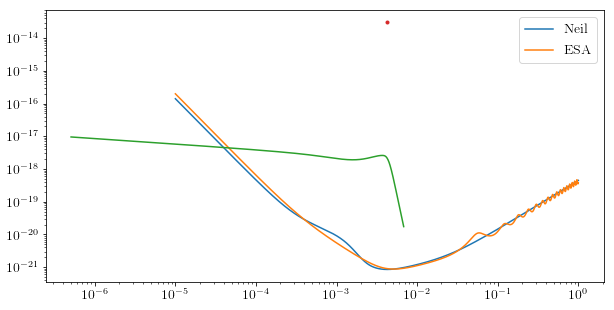

In [13]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_1.fT,instrument_1.h_n_f,label='Neil')
plt.loglog(instrument_2.fT,instrument_2.h_n_f,label='ESA')
plt.loglog(source_1.f,source_1.Get_CharStrain())
plt.loglog(source_1.f_init,source_1.h_gw,'.')
plt.legend()
plt.show()

In [14]:
model_3 = 0
instrument_3 = Get_Model(model_3)
print(instrument_3.name)
model_4 = 1
instrument_4 = Get_Model(model_4)
print(instrument_4.name)

ET
aLIGO


In [15]:
source_2 = Get_Source(model_4)
[M,q,chi1,chi2,z,inc] = source_2.Get_Current_Source_Vals()
source_2.Default_Setup(M,q,chi1,chi2,z,inc,instrument_4)

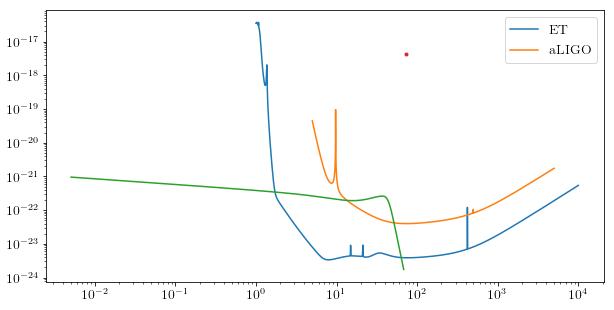

In [16]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_3.fT,instrument_3.h_n_f,label='ET')
plt.loglog(instrument_4.fT,instrument_4.h_n_f,label='aLIGO')
plt.loglog(source_2.f,source_2.Get_CharStrain())
plt.loglog(source_2.f_init,source_2.h_gw,'.')
plt.legend()
plt.show()

In [17]:
model_5 = 2
instrument_5 = Get_Model(model_5)
print(instrument_5.name)
model_6 = 3
instrument_6 = Get_Model(model_6)
print(instrument_6.name)

NANOGrav
SKA


In [18]:
source_3 = Get_Source(model_6)
[M,q,chi1,chi2,z,inc] = source_3.Get_Current_Source_Vals()
source_3.Default_Setup(M,q,chi1,chi2,z,inc,instrument_6)

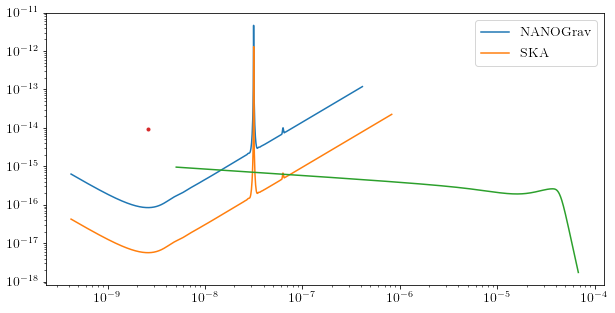

In [19]:
plt.figure(figsize=(10,5))
plt.loglog(instrument_5.fT,instrument_5.h_n_f,label='NANOGrav')
plt.loglog(instrument_6.fT,instrument_6.h_n_f,label='SKA')
plt.loglog(source_3.f,source_3.Get_CharStrain())
plt.loglog(source_3.f_init,source_3.h_gw,'.')
plt.legend()
plt.show()

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


In [23]:
model = 5
instrument = Get_Model(model)
source = Get_Source(model)
source.Set_Instrument(instrument)
start = time.time()
[sample_x,sample_y,SNRMatrix] = SNc_v3.getSNRMatrix(source,instrument,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


211.7817656993866


50.06400489807129

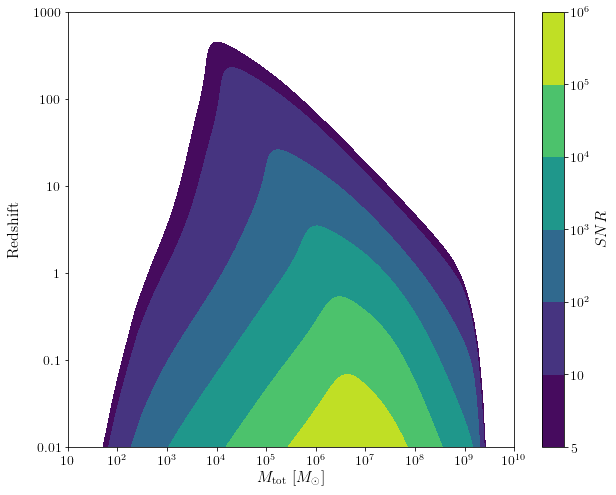

In [24]:
SNc_v3.plotSNR(source.source_var_dict,instrument.inst_var_dict,var_x,sample_x,var_y,sample_y,SNRMatrix)

# Whole Hog Creation of SNR Matrices and Samples

In [ ]:
for model in range(5):
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = SNc_v3.getSNRMatrix(source,instrument,\
                                             var_x,sampleRate_x,var_y,sampleRate_y)
    end = time.time()
    SNc_v3.saveSNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    SNc_v3.plotSNR(source_var_dict_mod,inst_var_dict_mod,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=True)
    print('Model: ',list(inst_var_dict_mod.keys())[0],', EOB Model: ',diff_mod,' done. t = : ',end-start)